 # Home bias in beer reviews

The following section details the analysis of the home bias effect in beer reviews, ie. do consummers rate local beers higher or lower than foreign ones.
We define a review to be "local" if the beer and the reviewer are from the same country (the country of the beer is taken to be the location of the main brewery). A contrario, the review is "foreign" if the country of the user and the beer differ. The hypothesis of home bias can be formalized as follows:

H0: $\mu_{local} = \mu_{foreign}$, the home bias effect is not present

H1: $\mu_{local} \neq \mu_{foreign}$, the home bias effect is present, either positively (local > foreign) or negatively (foreign > local)

To test this hypothesis, we divide or dataset into two groups: one with local reviews (treatment) and one with foreign reviews (control). We then try to reject the null-hypothesis using a t-test on the overall rating of the review.

To account for differences in user level of criticism and beer quality, we perform a 1-to-1 matching of reviews between the two groups. After investigating propensity using random forest (low prediction power), minimum weight matching on biases vectors recovered from Matrix Factorization (too slow to run on the whole dataset), we finally settled on an approximate stochasic matching. Reviews are binned based on the user beer and biases and groups balanced within each bin. The results show a small but significant preference for local over foreign reviews. More interestingly, when we group reviews per country, we notice that most of the top countries actually rate foreign beers higher, with the exception of the US and Belgium. Differences are also present on a per US state basis, altough less noticeable.

In [58]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
import warnings
from scipy.stats import ttest_ind
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 500)
img_path = "./Images/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# load the data
df = pickle_load('./Data/' + 'df_ba_ratings_filtered_beers_merged_users')
# define the treatment variable
df["treatment"] = df.apply(lambda row: 1 if row["user_country"] == row["beer_country"] else 0, axis=1)

 ## Preliminary data exploration

 In order to assess the effect of home bias, let's first explore the rate of local reviews per beer to se if we can further compare the treatment and control groups.

In [60]:
# create a feature "number of reviews" for each beer
df_groupby_beer = df.groupby(by = "beer_id").agg({"beer_id": "count", "treatment": "sum"})
df["nb_reviews_per_beer"] = df.apply(lambda row: df_groupby_beer.loc[row["beer_id"]]["beer_id"], axis=1)
# same for number of local and foreign reviews
df["nb_reviews_per_beer_local"] = df.apply(lambda row: df_groupby_beer.loc[row["beer_id"]]["treatment"], axis=1)
df["nb_reviews_per_beer_foreign"] = df["nb_reviews_per_beer"] - df["nb_reviews_per_beer_local"]
# compute the fraction of local reviews
df["share_local_reviews"] = df["nb_reviews_per_beer_local"] / df["nb_reviews_per_beer"]


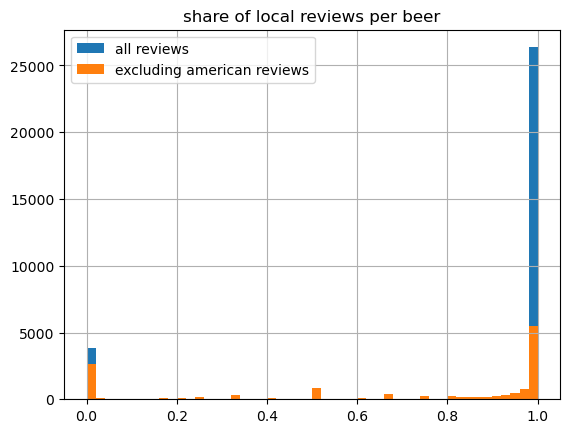

In [61]:
# plot the proportion of local reviews for each beer
groupby_beer = df.groupby(by="beer_id").agg({"share_local_reviews": "mean"})
groupby_beer["share_local_reviews"].hist(bins=50, label = "all reviews")

# removing american reviews
groupby_beer_no_us = df[df["user_country"] != "United States"].groupby(by="beer_id").agg({"share_local_reviews": "mean"})
groupby_beer_no_us["share_local_reviews"].hist(bins=50, label = "excluding american reviews")
plt.title("share of local reviews per beer")
plt.legend()
plt.show()


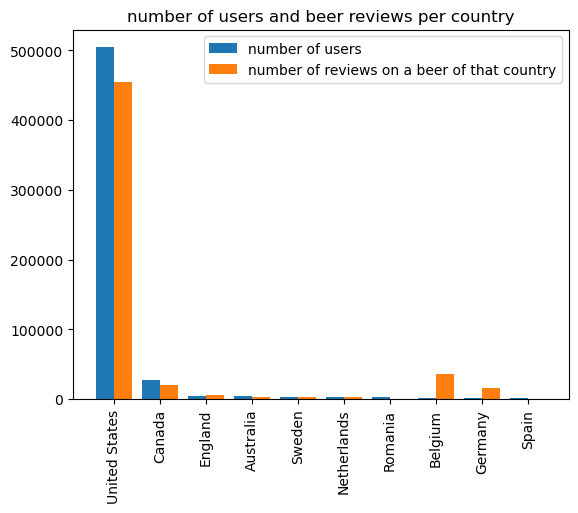

In [62]:
# put the two bar plot on the same figure
groupby_country = df.groupby(by="user_country").agg({"beer_id": "count"}).sort_values(by="beer_id", ascending=False)
x_axis = np.arange(10)
x_label = groupby_country.head(10).index
plt.bar(x_axis-0.2, groupby_country.head(10)["beer_id"], 0.4, label="number of users")
groupby_country = df.groupby(by="beer_country").agg({"beer_id": "count"}).reindex(x_label)
plt.bar(x_axis+0.2, groupby_country.head(10)["beer_id"], 0.4, label="number of reviews on a beer of that country")
plt.title("number of users and beer reviews per country")
plt.xticks(x_axis, x_label, rotation=90)
plt.legend()
plt.show()

 The distribution of local reviews makes sense. most of the users are concentrated in the us. Therefore a beer from the us is mostly rated by locals and an beer with fewer user in its country of origin (for example Belgium or Germany) mostly receives foreign reviews (as seen on the second plot).

 Looking at this very skewed distribution, it might make sense to subset the data to beers with a balanced distribution of local and foreign reviews (at least 10% of each). Let's see how many beers we would have to remove to get a balanced distribution.

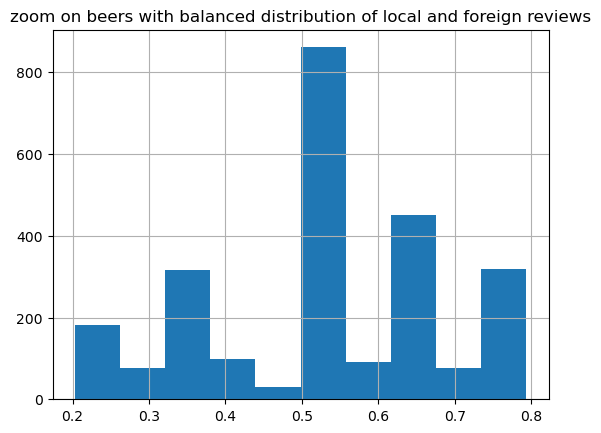

fraction of beers with balanced distribution of local and foreign reviews:  0.03306904161972557


In [63]:
# how many beers do have a somewhat balance distribution ? (20-80%)
groupby_beer[(groupby_beer["share_local_reviews"] > 0.2) & (groupby_beer["share_local_reviews"] < 0.8)]["share_local_reviews"].hist()
plt.title("zoom on beers with balanced distribution of local and foreign reviews")
plt.show()
# what is the fraction of beers with balanced distribution of local and foreign reviews ?
df_balanced = df[df["beer_id"].isin(groupby_beer[(groupby_beer["share_local_reviews"] > 0.2) & (groupby_beer["share_local_reviews"] < 0.8)].index)]

print("fraction of beers with balanced distribution of local and foreign reviews: ", len(df_balanced) / len(df))


 subset the data to beers with balanced distribution of local and foreign reviews leaves only about 3% of the number of total reviews, which will make it difficult to draw any conclusions. However, this primary analysis shows that there is a need to find a way to balance the treatment and control groups, using for example propensity score matching.

 ## Baseline: home bias analysis without any matching

 Eventhough the data is not balanced, let's first run a simple t-test to see if there is a significant difference in ratings between local and foreign reviews (prior to matching).

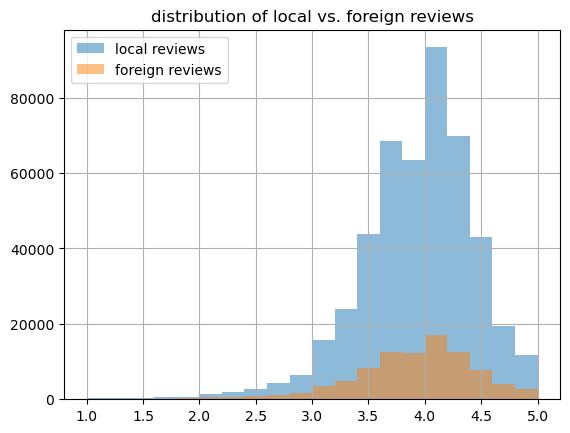

t-test on the mean ratings of local and foreign reviews:
t-statistic:  17.91276071481866
p-value:  1.1590426488755263e-71
average difference of mean ratings between treatment and control 0.03541338766194091


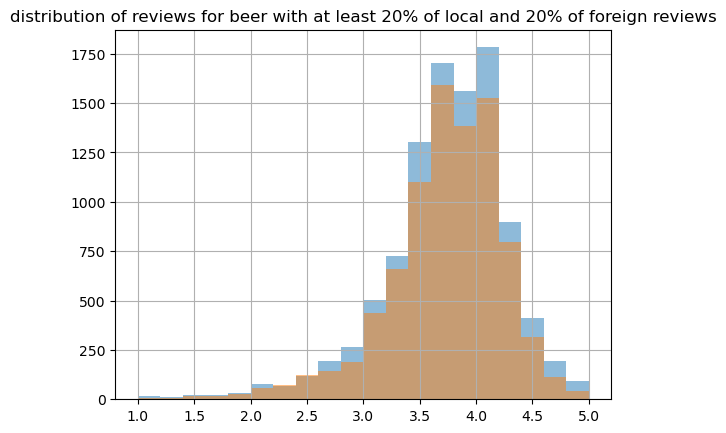

t-test on the mean ratings of local and foreign reviews:
t-statistic:  1.080983474762789
p-value:  0.2797186346557066
average difference of mean ratings between treatment and control 0.008383189453954998


In [64]:
# plot the rating distribution of the treatment and control groups prior to matching
df[df["treatment"] == 1]["rating"].hist(bins=20, alpha=0.5, label="local reviews")
df[df["treatment"] == 0]["rating"].hist(bins=20, alpha=0.5, label="foreign reviews")
plt.legend()
plt.title("distribution of local vs. foreign reviews")
plt.show()
# run a t-test to see if there is a significant difference in ratings between reviews with treatment = 1 and reviews with treatment = 0 (prior to matching)
res = ttest_ind(df[df["treatment"] == 1]["rating"], df[df["treatment"] == 0]["rating"], equal_var=False)
# print results of the t-test
print("t-test on the mean ratings of local and foreign reviews:")
print("t-statistic: ", res[0])
print("p-value: ", res[1])
print("average difference of mean ratings between treatment and control", df[df["treatment"] == 1]["rating"].mean() - df[df["treatment"] == 0]["rating"].mean())

# now if we subset to beer with at least 10% of foreign reviews and 10% of local reviews
df_balanced = df[(df["share_local_reviews"] > 0.2) & (df["share_local_reviews"] < 0.8)]
df_balanced[df_balanced["treatment"] == 1]["rating"].hist(bins=20, alpha=0.5, label="local reviews")
df_balanced[df_balanced["treatment"] == 0]["rating"].hist(bins=20, alpha=0.5, label="foreign reviews")
plt.title("distribution of reviews for beer with at least 20% of local and 20% of foreign reviews")
plt.show()

# run t-test
res = ttest_ind(df_balanced[df_balanced["treatment"] == 1]["rating"], df_balanced[df_balanced["treatment"] == 0]["rating"], equal_var=False)
print("t-test on the mean ratings of local and foreign reviews:")
print("t-statistic: ", res[0])
print("p-value: ", res[1])
print("average difference of mean ratings between treatment and control", df_balanced[df_balanced["treatment"] == 1]["rating"].mean() - df_balanced[df_balanced["treatment"] == 0]["rating"].mean())

 The results seem to show some significance in the home bias. Indeed, the users seem to give on average 0.03 points more toward local beers compared to foreign ones. However, as seen in the previous, the huge imbalances in the dataset lead to a lot of beer with either only local reviews or only foreign reviews. Because of that the result we see might be caused by other factors such as the country of origine of the beer or its quality. Therefore, we need to mitigate this imbalance in the dataset before running the analysis. However, if we subset only to beers with comparable amount of local and foreign reviews, the dataset will be too small to run a meaningful analysis. Therefor, we will try propensity score matching method to balance the dataset.

 ## Group matching

 ### propensity score calculcation using random forest

 First, we will try a random forest classifier to calculate the propensity score, ie. the probability of a user to rate local or foreign beer:

 $p = Pr(country_{user} = country_{beer} | covariates)$
 
 Random forest is chosen over logistic regression because it can better deals with categorical features (such as country or style class). The classifier will be trained on the following features:
 - avg user rating
 - number of reviews
 - beer style class
 - beer average rating
 - beer country
 
 we cannot use user country and beer country  simultaneously beause they are already part of the treatment. Indeed, the classifier would then just have to check if they are equal or not to decide on the treatment/control group probabilities.

In [ ]:
# add feature of average ratings given by the user
df_users = df.groupby(by = "user_id").agg({"rating": "mean"})
df["avg_user_rating"] = df.apply(lambda row: df_users.loc[row["user_id"]]["rating"], axis=1)

# categories the style class
df["style_class_cat"] = df["style_class"].astype("category").cat.codes
# categories the country
df["beer_country_cat"] = df["beer_country"].astype("category").cat.codes

In [ ]:
# feature list
feature_list = ["avg_user_rating", "nbr_reviews", "style_class_cat", "avg_beer_rating", "beer_country_cat"]
X = df[feature_list].values
# create label vector (treatment column)
y = df["treatment"].values

In [ ]:
# split into train and test set
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix

def random_forest_propensity(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train a random forest classifier
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    clf.fit(X_train, y_train)

    # get the probabilities on the test set
    y_pred = clf.predict_proba(X_test)[:,1]
    # predict the treatment with a threshold of 0.5
    y_pred_treated = clf.predict(X_test)

    # measure f1 score
    print("f1 score: ", f1_score(y_test, y_pred_treated))
    # print confusion matrix
    print(confusion_matrix(y_test, y_pred_treated))

    return y_pred

y_pred = random_forest_propensity(X, y)

f1 score:  0.9522810751081963
[[10150  8032]
 [ 1296 93075]]


 Eventhough the f1 score looks high, the predictor isn't very acurate for the foreign group (first line of the confusion matrix). The predictor is very much biased toward predicting treatment because the dataset is very unbalanced. In the case of predicting control, the model is wrong nearly 50% of the time.
 To better assess the quality of the mdel, we filter the review dataset to only keep countries with at least 1000 reviews (top 8 countries). We then balance our dataset by randomly sampling 1000 reviews per country.

In [ ]:
g = df.groupby("user_country").count().sort_values(by="beer_id", ascending=False)
# filter to countries in g with at least 1000 reviews
countries = g[g["beer_id"] >= 1000].index
df_topcountries = df[df["user_country"].isin(countries)] # 8 countries
g = df_topcountries.groupby("user_country")
def sampling_k_elements(group, k=1000):
    if len(group) < k:
        return group
    return group.sample(k)

df_topcountries_balanced = df_topcountries.groupby('user_country').apply(sampling_k_elements).reset_index(drop=True)
# check if we have 1000 reviews per country
df_topcountries_balanced.groupby("user_country").count()


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,user_nbr_ratings,nbr_reviews,user_name_y,joined,user_location,user_state,user_country_code,beer_country,beer_state,beer_country_code,style_class,avg_beer_rating,user_average_aroma,user_average_appearance,user_average_taste,user_average_palate,user_average_overall,user_average_rating,aroma_rescaled,appearance_rescaled,taste_rescaled,palate_rescaled,overall_rescaled,rating_rescaled,treatment,nb_reviews_per_beer,nb_reviews_per_beer_local,nb_reviews_per_beer_foreign,share_local_reviews,avg_user_rating,style_class_cat,beer_country_cat
user_country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Australia,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,0,1000,1000,128,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Belgium,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,0,1000,1000,52,998,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Canada,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,0,1000,1000,240,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
England,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,0,1000,1000,133,999,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Germany,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,0,1000,1000,209,997,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Netherlands,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,0,1000,1000,130,999,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Romania,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,0,1000,1000,148,999,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Sweden,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,0,1000,1000,186,999,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
United States,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,871,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


In [ ]:
# check if random forest performance
X = df_topcountries_balanced[["avg_user_rating", "nbr_reviews", "style_class_cat", "avg_beer_rating"]].values
# create label vector (treatment column)
y = df_topcountries_balanced["treatment"].values
y_pred = random_forest_propensity(X, y)

f1 score:  0.6073059360730593
[[580 358]
 [330 532]]


 This analysis confirms than when the dataset is balanced, the random forest classifier is bad at predicting treatment and control group probabilities (f-score is low). This is because the features available are not good enough to predict the treatment/control group. We will try to use matrix factorization with biases as an alternative method to balance our dataset.

 ### Matching using matrix factorization with biases vectors

 The motivation of the method is the following: some beers are arguably of better quality than others. Similarly some user are more critical in their ratings than others.

 If we want to isolate the effect of home bias on the rating, we should try to match reviews from the treatment and control groups which have similar beer quality and user criticism. We can retrieve those bias (for the users and the beers) using matrix factorization with biases, as demonstrated in the [Netflix Prize competition](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf). We compute user and beer bias vectors by performing matrix factorization with biases on the user-beer review matrix. Each rating is approximated by:
 
 $\hat r_{user,beer} = \mu + b_{user} + b_{beer} + q_{beer}^T p_{user}$
 
 from wich we recover the biases $b_{user}$ and $b_{beer}$.
 
 We then use those biases to match reviews between the treatment and control groups. The matching is done by minimizing the squared distance between the user biases of review (A, B) and the beer biases of review (A, B).

In [66]:
def reset_id(df, col):
    # reset beer id and user id to be from 0 to nb_beer and nb_user
    df[col] = df[col].astype("category").cat.codes
    return df

# Matrix factorization with biases
import surprise.prediction_algorithms.matrix_factorization as mf
from surprise import Reader, Dataset

def get_biases(df, plot=False, verbose=False):
    # returns the biases vectors for the beers and the users as two new columns in the dataframe
    df = reset_id(df, "beer_id")
    df = reset_id(df, "user_id")
    algo = mf.SVD(n_factors=100, n_epochs=20, biased=True, lr_all=0.005, reg_all=0.02, verbose=verbose) #default parameters
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df[["user_id", "beer_id", "rating"]].rename(columns={"user_id": "userID", "beer_id": "itemID", "rating": "rating"}), reader)
    user_bias = algo.fit(data.build_full_trainset()).bu
    beer_bias = algo.fit(data.build_full_trainset()).bi
    if plot:
        plt.hist(user_bias, alpha = 0.5, bins = 100, label="user bias", density=True)
        plt.hist(beer_bias, alpha = 0.5, bins = 100, label="beer bias", density=True)
        plt.xlabel("Bias")
        plt.ylabel("Density")
        plt.title("Histogram of user and beer biases")
        plt.legend()
        plt.show()
    df["user_bias"] = df.apply(lambda row: user_bias[row["user_id"]], axis=1)
    df["beer_bias"] = df.apply(lambda row: beer_bias[row["beer_id"]], axis=1)
    return df

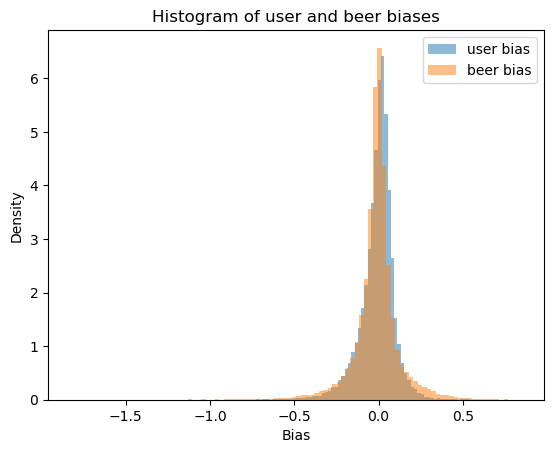

In [ ]:
df = get_biases(df, plot=True)

 The following algorithm creates a bipartite graph where each node of the control group is connected to each node of the treatment group. The weight of the edge is the squared distance between the user bias and the beer bias of the two reviews. The algorithm then finds the minimum weight matching between the two groups. The matching is done using the [Hungarian algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm).
 The main issue of this approach is that we need to create 3.1e11 ($O(n^2)$) connections between the nodes of the two groups, which would simply take to loong. We therefore take a sample of the reviews to try the algorithm.

In [67]:
import networkx as nx

def graph_matching(df, concat = False):
    # reset index reviews
    df = df.reset_index()
    df["idx"] = df.index
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"
    B.add_nodes_from(df[df["treatment"] == 0]["idx"], bipartite=0)
    B.add_nodes_from(df[df["treatment"] == 1]["idx"], bipartite=1)
    # Add edge between nodes of opposite node sets. The weights are the difference in user_bias squared plus the difference in beer_bias squared
    control_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
    treatment_nodes = set(B) - control_nodes
    for control in control_nodes:
        for treatment in treatment_nodes:
            B.add_edge(control, treatment, weight=(df.loc[control]["user_bias"] - df.loc[treatment]["user_bias"])**2 + (df.loc[control]["beer_bias"] - df.loc[treatment]["beer_bias"])**2)
    # find minimum weight matching of the graph
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        matching_double = nx.bipartite.minimum_weight_full_matching(B, top_nodes = control_nodes)
    
    # the key-value pair in matching appear twice, so we remove from matching all keys which are in the treatment group
    matching = {k: v for k, v in matching_double.items() if k in control_nodes}

    # get the ids of the reviews in the treatment and control groups
    control_ids = [k for k, v in matching.items()]
    treatment_ids = [v for k, v in matching.items()]
    # create a new df with the matching
    df_control = df.loc[control_ids]
    df_treatment = df.loc[treatment_ids]

    # add weight to the dataframe
    df_control["distance"] = df_control.apply(lambda row: np.sqrt(B[row["idx"]][matching_double[row["idx"]]]["weight"]), axis=1)
    df_treatment["weight"] = df_treatment.apply(lambda row: np.sqrt(B[matching_double[row["idx"]]][row["idx"]]["weight"]), axis=1)

    if concat:
        return pd.concat([df_control, df_treatment])
    else:
        return df_control, df_treatment

Ttest_indResult(statistic=1.0037546866982379, pvalue=0.31657035728807126)
-0.05780701754385964


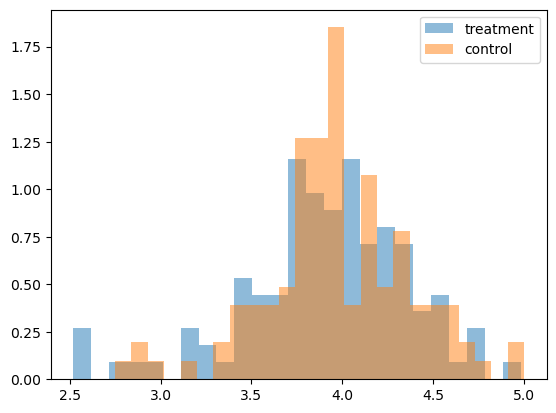

In [ ]:
# run the graph matching algorithm (slow)
df_sample = df.sample(frac = 0.001)

df_control, df_treatment = graph_matching(df_sample)

# run a t-test on rating with the matching dataframe
res = ttest_ind(df_control["rating"], df_treatment["rating"])
print(res)
# comput the difference of mean rating between control and treatment
print(df_treatment["rating"].mean() - df_control["rating"].mean())

#plot the distribution of rating for the matching
plt.hist(df_treatment["rating"], alpha=0.5, label="treatment", bins=25, density=True)
plt.hist(df_control["rating"], alpha=0.5, label="control", bins=25, density=True)
plt.legend()
plt.show()


 After propensity matching, we still find some difference in the mean rating between the control and treatment groups. However, the result is not significant because the sample size is too small. Since it is impossible to run the algorithm on the whole dataset, we will try to develop an approximate matching approach.

 ### Matrix factorization and discrete approximate matching

 The idea of this method is the following: after computing the user and beer biases, we match each local review 1-1 with another foreign review where the user bias and beer bias are close, ie within the same bin. This minimize the number of possible connections to $O(m^2)$ where m is the number of points in the bin. For example, in 1D, if we bin the data with 10 equal frequency bins, the amount of edges for each graph has effectively been divided by $10^2 = 100$ (but as counter-effect, there are now 10 problems to solve). In the case where bin size increase to infinity (only 1 bin), we recover the optimal solution. The bins can be visualized on the following plot:

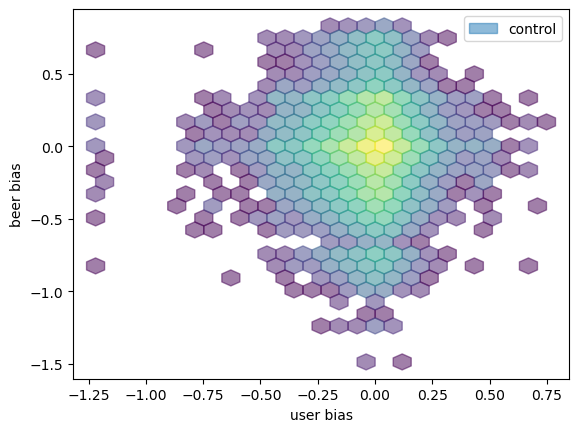

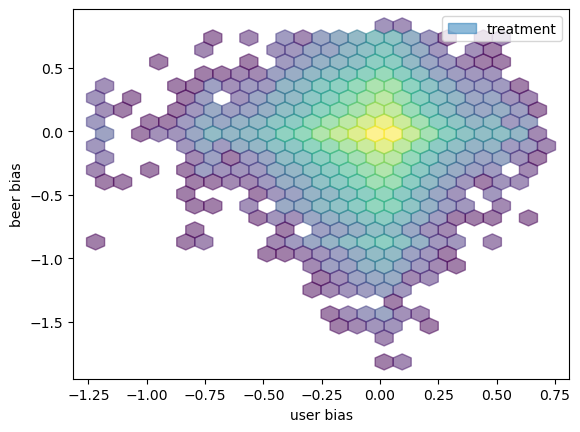

In [ ]:
# 2D hexagonal heat map plot of user bias and beer bias for treatment and control groups
df = get_biases(df, plot=False)
plt.hexbin(df[df["treatment"] == 0]["user_bias"], df[df["treatment"] == 0]["beer_bias"], bins = 'log', gridsize=25, label="control", alpha=0.5)
plt.xlabel("user bias")
plt.ylabel("beer bias")
plt.legend()
plt.show()
plt.hexbin(df[df["treatment"] == 1]["user_bias"], df[df["treatment"] == 1]["beer_bias"], bins = 'log', gridsize=25, label="treatment", alpha=0.5)
plt.xlabel("user bias")
plt.ylabel("beer bias")
plt.legend()
plt.show()

 The idea behind this method is that it is very unlikely for a point to be matched with another point outside its neighbourhood (bin) since the euclidiean distance would be to big.
 When binning the user and beer bias, we have 4 different options:
 - equal width: the bins have the same width
 - equal width log: the bins have the same width in log scale
 - equal frequency: we bin each axis (user_bias, beer_bias) so that each bin has the same number of points. However, in practice the 2D bins are not equal in size. Bins on the extrem corners of the space have less points than bins in the middle.
 - equal frequency log: same idea but for log re-scaled biases.

 To choose which binning method to use, we can compare the average pair euclidean distance for each method.
 The implementation of this discretized approximate graph matching algorithm is based on the previous function graph_matching and is included in the following code. However, in practice, we found that the algorithm is still too slow to run on the whole dataset on our machine. A test on a sample of the dataset is shown below.

In [68]:

def log_bias(df):
    # create a new column with the log of bias (we add one to deal with the case where the bias is 0)
    df["user_bias_log"] = df["user_bias"].apply(lambda x: np.log(x+1))
    df["beer_bias_log"] = df["beer_bias"].apply(lambda x: np.log(x+1))
    return df

def discretized_graph_matching(df):
    if len(df[df["treatment"] == 1]) == 0 or len(df[df["treatment"] == 0]) == 0:
        return None
    else:
        return graph_matching(df, concat=True)

def bin_data(df, bin_method, bins=20, column1="user_bias", column2="beer_bias"):
    # create a new column with the discretized bias

    pd.options.mode.chained_assignment = None
    if bin_method == "equal_frequency":
        df["user_bias_discretized"] = pd.qcut(df[column1], bins, labels=False, duplicates='drop')
        df["beer_bias_discretized"] = pd.qcut(df[column2], bins, labels=False, duplicates='drop')
    elif bin_method == "equal_width":
        df["user_bias_discretized"] = pd.cut(df[column1], bins, labels=False, duplicates='drop')
        df["beer_bias_discretized"] = pd.cut(df[column2], bins, labels=False, duplicates='drop')
    elif bin_method == "log_equal_frequency":
        df = log_bias(df)
        df["user_bias_discretized"] = pd.qcut(df[column1 + "_log"], bins, labels=False, duplicates='drop')
        df["beer_bias_discretized"] = pd.qcut(df[column2 + "_log"], bins, labels=False, duplicates='drop')
    elif bin_method == "log_equal_width":
        df = log_bias(df)
        df["user_bias_discretized"] = pd.cut(df[column1 + "_log"], bins, labels=False, duplicates='drop')
        df["beer_bias_discretized"] = pd.cut(df[column2 + "_log"], bins, labels=False, duplicates='drop')
    else:
        raise ValueError("bininng method not supported")
    return df


def discretized_matching(df, bin_method = "equal_frequency", bins=20, column1="user_bias", column2="beer_bias"):
    #approximately matches each review to a review in the other group by binning the user and beer bias and then balancing each bin
    df = bin_data(df, bin_method, bins, column1, column2)
    
    # performs approximate graph matching within each bin
    df_balanced = df.groupby(["user_bias_discretized", "beer_bias_discretized"]).apply(lambda x: discretized_graph_matching(x)).reset_index(drop=True)

    return df_balanced

In [ ]:
# run-test with exact matching and equal frequency
df_balanced = discretized_matching(df.sample(frac = 0.001, random_state=42), bin_method="equal_frequency", bins = 20)
# sanity check
# sanity check if there are the same number of reviews in treatment and control groups
df_balanced.groupby("treatment").count()

#print average distance
print("average distance between the matching reviews")
print(df_balanced["distance"].mean())


average distance between the matching reviews
0.02973107003699643


 ### Stochastic method
 In order to perform the matching of the whole dataset in reasonnable time, we finnally decided to use a stochastic relaxation of the algorithm above. The idea is to bin the user and beer bias and then to balance each bin by sampling the majoritarian group (treatment or control) without replacement. The number of samples is the number of reviews in the minoritarian group. Altough this algorithm will result in a less precise matching than the exact or discretized graph matching presented above, it will still give a reasonnable approximation of the perfect matching. Once each bin is balanced, and given that bins are sufficiently small, we can expect that the average distance between the potential matching reviews will be small. This solution doesn't require to find exact pairs and is thus linear in the number of reviews. The implementation of this algorithm is included in the following code.

In [69]:

def random_balance(row, compute_distance=True):
    treatment = row[row["treatment"] == 1]
    control = row[row["treatment"] == 0]
    if len(treatment) == 0 or len(control) == 0:
        return None
    if len(treatment) > len(control):
        treatment = treatment.sample(len(control), random_state=42)
    else:
        control = control.sample(len(treatment), random_state=42)
    # compute the distance of each review to the mean of the treatment and control groups
    if compute_distance:
        treatment["distance"] = treatment.apply(lambda x: np.sqrt((x["user_bias"] - treatment["user_bias"].mean())**2 + (x["beer_bias"] - treatment["beer_bias"].mean())**2), axis=1)
        control["distance"] = control.apply(lambda x: np.sqrt((x["user_bias"] - control["user_bias"].mean())**2 + (x["beer_bias"] - control["beer_bias"].mean())**2), axis=1)
    return pd.concat([treatment, control])

# redefine discretized_matching to include the random balancing method
def discretized_matching_updated(df, bin_method = "equal_frequency", match_method = "random_matching", bins=20, column1="user_bias", column2="beer_bias", compute_distance=True):
    #approximately matches each review to a review in the other group by binning the user and beer bias and then balancing each bin
    df = get_biases(df)
    df = bin_data(df, bin_method, bins, column1, column2)

    # choose matching method
    if match_method == "random_matching":
        df_balanced = df.groupby(["user_bias_discretized", "beer_bias_discretized"]).apply(lambda x: random_balance(x, compute_distance)).reset_index(drop=True)
    elif match_method == "graph_matching":
        df_balanced = df.groupby(["user_bias_discretized", "beer_bias_discretized"]).apply(lambda x: discretized_graph_matching(x)).reset_index(drop=True)
    else:
        raise ValueError("matching method not supported")
    return df_balanced


To choose the binning method, we run the algorithm with different binning methods and different number of bins and then compare the performance of the matching. Since the stochastic algorithm doesn't provide us the pairs of the 1-1 matching, we use as a proxy the average distance of each point to its bin center. We then select the binning method that gives the smallest average distance.

In [ ]:
# assessing the quality of the matching for each binning option
df_sample = df
bin_methods = ["equal_frequency", "equal_width", "log_equal_frequency", "log_equal_width"]
for method in bin_methods:
    print(method)
    df_balanced = discretized_matching_updated(df_sample, bin_method=method, match_method="random_matching", bins = 20)
    # total number of reviews in the balanced dataframe
    print("total number of reviews in the balanced dataframe")
    print(len(df_balanced))
    # average distance between the matching reviews
    print("average distance between the matching reviews")
    print(df_balanced["distance"].mean())
    # run a t-test on rating with the balanced dataframe
    res = ttest_ind(df_balanced[df_balanced["treatment"] == 0]["rating"], df_balanced[df_balanced["treatment"] == 1]["rating"])
    print("results of the test:")
    print("p-value:", res[1], "statistic:", res[0])
    print(df_balanced[df_balanced["treatment"] == 1]["rating"].mean() - df_balanced[df_balanced["treatment"] == 0]["rating"].mean())


equal_frequency
total number of reviews in the balanced dataframe
182366
average distance between the matching reviews
0.03182699345719662
results of the test:
p-value: 1.2015897866904834e-14 statistic: -7.716511161800363
0.01920127655374415
equal_width
total number of reviews in the balanced dataframe
181934
average distance between the matching reviews
0.04051770659547932
results of the test:
p-value: 1.8853421542327175e-24 statistic: -10.20636478178376
0.025501555509140683
log_equal_frequency
total number of reviews in the balanced dataframe
182268
average distance between the matching reviews
0.03108354065650935
results of the test:
p-value: 2.1958332013185463e-11 statistic: -6.692791311754599
0.016644611231813933
log_equal_width
total number of reviews in the balanced dataframe
181686
average distance between the matching reviews
0.07767649816904336
results of the test:
p-value: 3.7083920245869883e-26 statistic: -10.581167687819114
0.02637946787314327


We can see that the log_equal_frequency method gives the best results. We will use this method for the rest of the analysis. Also, even though the binning reduces the number of possible edges between control and treatment groups, the number of edges is still $O(n^2)$ which makes it impossible to run on the full dataset. We will therefore use the random method to balance the dataset, which we suppose would give a similar approximation to the graph matching method.

## Home bias results and analysis

 We can run the stochastic matching on the full dataset, using log equal frequency binning, and perform a t-test between the rating of the two groups in the matched reviews dataset.

In [ ]:
df_balanced = discretized_matching_updated(df, bin_method="log_equal_frequency", match_method = "random_matching", bins = 20, compute_distance = False)

In [ ]:
# run a t-test on rating with the balanced dataframe
res = ttest_ind(df_balanced[df_balanced["treatment"] == 0]["rating"], df_balanced[df_balanced["treatment"] == 1]["rating"])
# print p-value
print("results of the test:")
print("p-value:", res[1], "statistic:", res[0])
# print difference of mean rating between control and treatment
mean_diff = df_balanced[df_balanced["treatment"] == 1]["rating"].mean() - df_balanced[df_balanced["treatment"] == 0]["rating"].mean()
print("difference in mean rating between two groups:", mean_diff)

results of the test:
p-value: 1.933532226442072e-12 statistic: -7.039683383731128
difference in mean rating between two groups: 0.0175275967257007


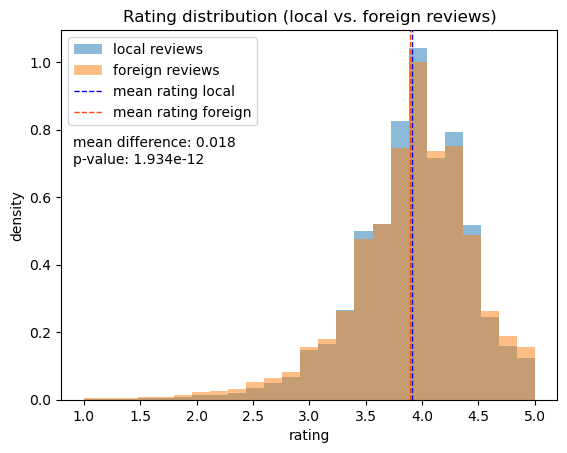

In [ ]:
# plot histogram of rating for treatment and control groups
plt.hist(df_balanced[df_balanced["treatment"] == 1]["rating"], label="local reviews", alpha = 0.5, bins = 25, density = True)
plt.hist(df_balanced[df_balanced["treatment"] == 0]["rating"], label="foreign reviews", alpha = 0.5, bins = 25, density = True)
plt.xlabel("rating")
plt.ylabel("density")
# add a vertical line at the mean rating
plt.axvline(df_balanced[df_balanced["treatment"] == 1]["rating"].mean(), color='b', linestyle='dashed', linewidth=1, label="mean rating local")
plt.axvline(df_balanced[df_balanced["treatment"] == 0]["rating"].mean(), color='orangered', linestyle='dashed', linewidth=1, label="mean rating foreign")
#add a legend with p value
plt.text(0.9, 0.75, "mean difference: " + str(round(mean_diff, 3)), fontsize=10)
plt.text(0.9, 0.7, "p-value: " + str(round(res[1], 15)), fontsize=10)
plt.legend()
plt.title("Rating distribution (local vs. foreign reviews)")
plt.savefig("Images/rating_distribution_homebias.jpg", dpi = 500)
plt.show()

c:\Users\matth\anaconda3\envs\ADA\lib\site-packages\seaborn\distributions.py:497: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

c:\Users\matth\anaconda3\envs\ADA\lib\site-packages\seaborn\distributions.py:498: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1040x800 with 0 Axes>

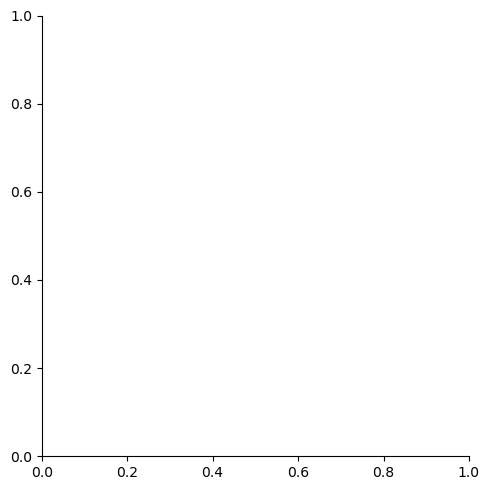

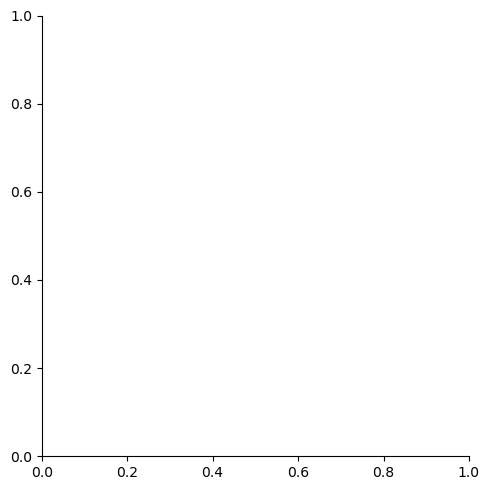

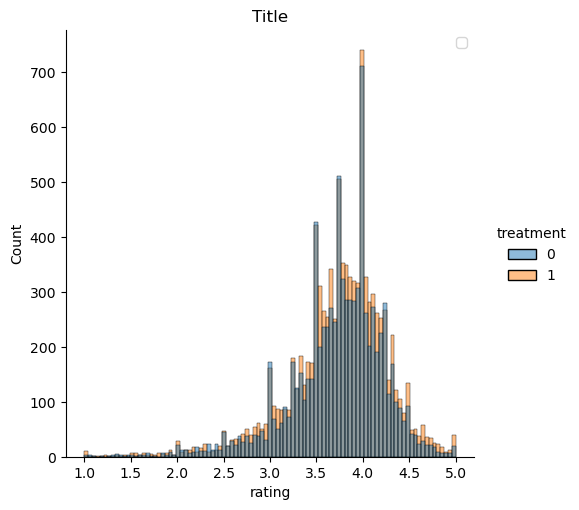

In [112]:
# plot with sns
import seaborn as sns
# Draw sns distribution plot for treatment and control groups
sns.displot(df_balanced, x="rating", hue="treatment")

# Decoration
plt.title('Title')
plt.legend()
plt.show()

In [70]:
np.random.seed(42)
def bootstrapping_function(treatment, control, level = 0.05, iterations = 1000):
    # boostrapping function to get the confidence interval
    # bootstrapping function
    # input: dataset, nb of iterations
    # output: overal mean, 95% confidence interval
    differences = []
    for i in range(iterations):
        treatment_sample = np.random.choice(treatment, size = len(treatment), replace = True)
        control_sample = np.random.choice(control, size = len(treatment), replace = True)
        differences.append(np.mean(treatment_sample) - np.mean(control_sample))
    
    differences.sort()
    return np.mean(differences), differences[int(np.ceil(level/2*iterations))], differences[int(np.floor(1-(level/2) * iterations))]

N_BOOSTRAP = 1000 #number of time we boostrap each dataset (be careful with runtimes)

In [71]:
diff_user_mean, diff_user_low, diff_user_high = bootstrapping_function(df_balanced["rating"].loc[df_balanced["treatment"] == 1], df_balanced["rating"].loc[df_balanced["treatment"] == 0], level = 0.05)

df_results = pd.DataFrame({"diff_user_mean": [diff_user_mean], "diff_user_low": [diff_user_low], "diff_user_high": [diff_user_high]})


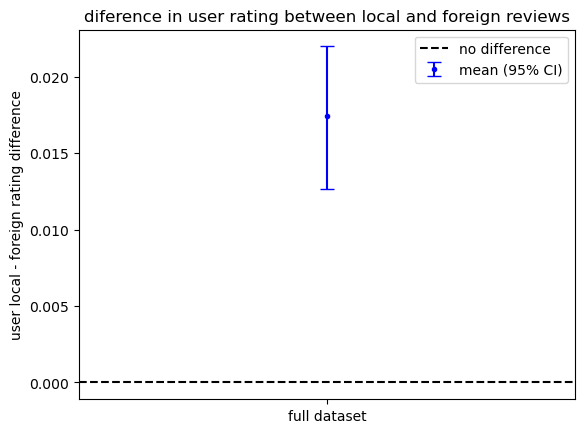

In [ ]:
df_results["err_low"] = df_results["diff_user_mean"] - df_results["diff_user_low"]
df_results["err_high"] = df_results["diff_user_high"] - df_results["diff_user_mean"]
fig, ax = plt.subplots()
plt.errorbar([i for i in range(len(df_results))], df_results["diff_user_mean"].to_numpy(), yerr=df_results[["err_low", "err_high"]].transpose().to_numpy(), barsabove=True, capsize = 5, fmt = '.b', label = "mean (95% CI)")
ax.axhline(0, 0, 1, linestyle = "--", color = "k", label = "no difference")
plt.legend()
plt.xticks([i for i in range(len(df_results))], ["full dataset"])
plt.ylabel("user local - foreign rating difference")
plt.title("diference in user rating between local and foreign reviews")
plt.show()

 The difference of distribution of rating between local and foreign reviews is almost indistinguishable. However, looking at the 95% confidence intervall, the effect is still statistically significant. We can conclude that the local beers are rated higher than the foreign beers, but not by much.

 ## Analysis per country:

 We can now perform the same analysis on the dataset per country. We will use the same discretized stochastic matching method as before and perform matching for each country separately. We will only consider the top 10 countries of the dataset to ensure that we have enough reviews for each country.
 since we are testing results for 10 countries, we need to correct for multiple testing. We will use the Sidak correction. The alpha value for the Sidak correction is $\alpha = 1 - (1-0.05)^\frac{1}{10} = 0.005 \%$, which will use to correct for multiple testing.

In [72]:
# sidak correction
alpha_1 = 1-(1-0.05)**(1/10)
print("The alpha value for the sidak correction is: ", alpha_1)

The alpha value for the sidak correction is:  0.005116196891823743


In [73]:
# get the results for each country

def homebias_per_region(df, region = "country"):
    list_results = []
    
    if region == "country":
        by_column = "user_country"
    elif region == "state":
        by_column = "user_state"
    else:
        raise ValueError("region must be 'country' or 'state'")
    # subset to the top 10 countries
    groupby_country = df.groupby(by=by_column).count().sort_values(by="beer_id", ascending=False)
    topten_country = groupby_country.index[:10]
    print(f"The top 10 {region} are: ", topten_country)
    df_topcountries = df[df[by_column].isin(topten_country)]

    # loop over the top 10 countries
    for country in topten_country:
        df_country = df_topcountries[df_topcountries[by_column] == country].copy()
        print(f"country: {country}, number of reviews: {len(df_country)}")
        df_country = get_biases(df_country)
        # perform matching of the country
        df_country = discretized_matching_updated(df_country, bin_method = "log_equal_frequency", match_method = "random_matching", bins = 5)
        # run a t-test on rating with the balanced dataframe
        res = ttest_ind(df_country[df_country["treatment"] == 1]["rating"], df_country[df_country["treatment"] == 0]["rating"])
        print(f"{country}: t-statistic: {res.statistic}, p-value: {res.pvalue}")
        # print difference of mean rating between control and treatment
        print("difference in rating:", df_country[df_country["treatment"] == 1]["rating"].mean() - df_country[df_country["treatment"] == 0]["rating"].mean())

        # compute confidence interval
        diff_user_mean, diff_user_low, diff_user_high = bootstrapping_function(df_country["rating"].loc[df_country["treatment"] == 1], df_country["rating"].loc[df_country["treatment"] == 0], level = alpha_1, iterations = 1000)

        #append results to list in key-value pairs
        list_results.append({"country": country, "diff_user_mean": diff_user_mean, "diff_user_low": diff_user_low, "diff_user_high": diff_user_high})

    df_results = pd.DataFrame(list_results)
    df_results["idx"] = [i for i in range(len(df_results))]
    
    return df_results, topten_country


In [74]:
df_results, topten_country = homebias_per_region(df, region = "country")
# save df_results as csv
df_results.to_csv("results_per_country.csv")

The top 10 country are:  Index(['United States', 'Canada', 'England', 'Australia', 'Sweden',
       'Netherlands', 'Romania', 'Belgium', 'Germany', 'Spain'],
      dtype='object', name='user_country')
country: United States, number of reviews: 504591
United States: t-statistic: 1.448505668528366, p-value: 0.14747828398256943
difference in rating: 0.00442146496921092
country: Canada, number of reviews: 27198
Canada: t-statistic: -20.21437554973254, p-value: 5.446624812381154e-90
difference in rating: -0.1350741782216618
country: England, number of reviews: 4429
England: t-statistic: -3.6066927835224964, p-value: 0.0003141289359327607
difference in rating: -0.061093502377179476
country: Australia, number of reviews: 4100
Australia: t-statistic: -13.29500334006107, p-value: 2.192197018907673e-39
difference in rating: -0.2508841985168284
country: Sweden, number of reviews: 2837
Sweden: t-statistic: -5.850934741729471, p-value: 5.563572964242447e-09
difference in rating: -0.144852569502949


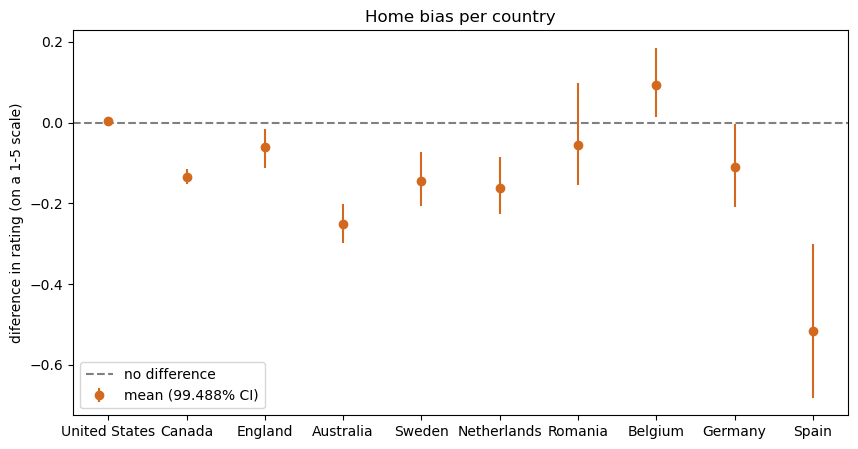

In [76]:
# plotting of the results

# computing error bars
df_results["err_low"] = df_results["diff_user_mean"] - df_results["diff_user_low"]
df_results["err_high"] = df_results["diff_user_high"] - df_results["diff_user_mean"]

# plotting
fig, ax = plt.subplots(figsize = (10, 5))
plt.errorbar([i for i in range(len(df_results))], df_results["diff_user_mean"].to_numpy(), yerr=df_results[["err_low", "err_high"]].transpose().to_numpy(), fmt = 'o', color = 'chocolate', label = f"mean ({(1 - alpha_1)*100:.3f}% CI)")
ax.axhline(0, 0, 1, linestyle = "--", color = "gray", label = "no difference")
plt.xticks([i for i in range(len(df_results))], topten_country)
plt.ylabel("diference in rating (on a 1-5 scale)")
plt.title("Home bias per country")
plt.legend(loc = "lower left")
plt.savefig("Images/homebias_confidence_intervall_countries.jpg", dpi = 500)
plt.show()

In [103]:
# plotting with plotly
import plotly.graph_objects as go

def plot_confidence_intervall(df_results, ticks, region = "country"):
    # round data confidence interval to 3 decimal places
    df_results["err_low"] = df_results["err_low"].round(3)
    df_results["err_high"] = df_results["err_high"].round(3)
    # round mean to 3 decimal places
    df_results["diff_user_mean"] = df_results["diff_user_mean"].round(3)
    fig = go.Figure(data=go.Scatter(
            x=ticks,
            y=df_results["diff_user_mean"].to_numpy(),
            error_y=dict(
                type='data',
                symmetric=False,
                array=df_results["err_high"].to_numpy(),
                arrayminus=df_results["err_low"].to_numpy(),)
            ))
    fig.add_hline(y=0.0, line_dash="dash", line_color="gray")
    # remove line between points
    fig.update_traces(mode='markers')
    # change colors to chocolate
    fig.update_traces(marker_color='chocolate')
    fig.update_layout(title=f"Home bias per {region}", xaxis_title=f"{region}", yaxis_title="diference in rating (on a 1-5 scale)")
    # update to white background
    fig.update_layout(template="plotly_white")
    # make points bigger
    fig.update_traces(marker_size=10)
    # make text bigger
    fig.update_layout(font_size=15)
    # save figure
    return fig

plotly_country = plot_confidence_intervall(df_results, ticks = topten_country, region = "country")

 Developping the analysis per country revealed a form of simpson's paradoxe. Altough the general dataset seem to be biased towards local beers, when analysing per country bias, we notice that 8 of the top 10 countries are biased towards foreign beers. This effect was hidden in the global analysis because the dataset mostly consists of reviews from the US, which is slightly positively biased towards local beers.

 While the best beer country is subjective, Belgium and US are widely considered as major beer countries according to this [top 13 best beer countries in the world](https://www.thrillist.com/drink/nation/the-best-beer-countries-in-the-world). Therefor, it makes sense that user from those countries are biased toward rating their local beer higher. However, this argument is limited because other countries such as England or the Netherlands are also famous beer countries but have a bias towards foreign beers.

 Bias towards foreign products might also be a result of consumer cosmopolitanism, an effect which described by  “the extent to which a consumer (1) exhibits an open-mindedness towards foreign countries and cultures, (2) appreciates the diversity brought about by the availability of products from different national and cultural origins, and (3) is positively disposed towards consuming products from foreign countries.” This effect also contributs to self identity, ie. “[the] frame of reference by which individuals evaluate their self-worth.” according to [Balabanis, G., Stathopoulou, A., & Qiao, J. (2019). Favoritism Toward Foreign and Domestic Brands: A Comparison of Different Theoretical Explanations. Journal of International Marketing](https://openaccess.city.ac.uk/id/eprint/23521/)

 ### Analysis for the us

Using the RateBeer dataset, we run the same analysis subsetting to only american beers and reviews. In this case the treatment variable is 1 if beer and user are from the same state, and 0 otherwise.

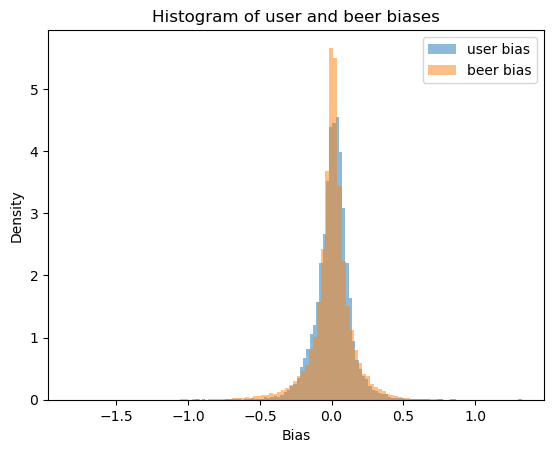

In [ ]:
df_us = pickle_load('./Data/' + 'df_rb_reviews_filtered_beers_merged_users')
df_us.dropna(subset=["beer_state"], inplace=True)
df_us["treatment"] = df_us.apply(lambda row: 1 if row["user_state"] == row["beer_state"] else 0, axis=1)
# get the results for the US
df_us = get_biases(df_us, plot = True)
df_us_balanced = discretized_matching_updated(df_us, bin_method="log_equal_frequency", match_method = "random_matching", bins = 10, compute_distance = False)

In [ ]:
# run a t-test on rating with the balanced dataframe
res_us = ttest_ind(df_us_balanced[df_us_balanced["treatment"] == 0]["rating"], df_us_balanced[df_us_balanced["treatment"] == 1]["rating"])
print("t-test on rating for the US")
print(f"t-statistic: {res.statistic}, p-value: {res.pvalue}")
# print difference of mean rating between control and treatment
mean_diff_us = df_us_balanced[df_us_balanced["treatment"] == 1]["rating"].mean() - df_us_balanced[df_us_balanced["treatment"] == 0]["rating"].mean()
print("difference in average rating:", mean_diff_us)

t-test on rating for the US
t-statistic: -7.039683383731128, p-value: 1.933532226442072e-12
difference in average rating: 0.014172977854400415


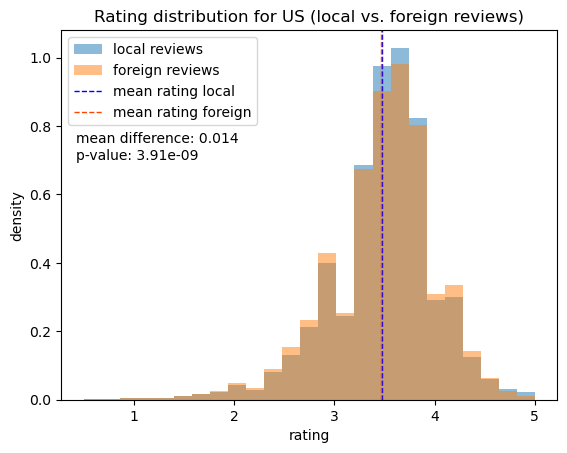

In [ ]:
# plot histogram of rating for treatment and control groups
plt.hist(df_us_balanced[df_us_balanced["treatment"] == 1]["rating"], label="local reviews", alpha = 0.5, bins = 25, density = True)
plt.hist(df_us_balanced[df_us_balanced["treatment"] == 0]["rating"], label="foreign reviews", alpha = 0.5, bins = 25, density = True)
plt.xlabel("rating")
plt.ylabel("density")
# add a vertical line at the mean rating
plt.axvline(df_us_balanced[df_us_balanced["treatment"] == 1]["rating"].mean(), color='b', linestyle='dashed', linewidth=1, label="mean rating local")
plt.axvline(df_us_balanced[df_us_balanced["treatment"] == 0]["rating"].mean(), color='orangered', linestyle='dashed', linewidth=1, label="mean rating foreign")
plt.text(0.42, 0.75, "mean difference: " + str(round(mean_diff_us, 3)), fontsize=10)
plt.text(0.42, 0.7, "p-value: " + str(round(res_us[1], 11)), fontsize=10)
plt.legend()
plt.title("Rating distribution for US (local vs. foreign reviews)")
plt.savefig("Images/rating_distribution_homebias_us.jpg", dpi = 500)
plt.show()

Looking at data for US states, we do observe similar distribution of the two groups as for the worldwide dataset. Here the difference is a bit smaller but still significant.
Let's run a similar analysis per state.

In [97]:
df_results_us, topten_states = homebias_per_region(df_us, region = "state")

The top 10 state are:  Index(['California', 'Pennsylvania', 'Illinois', 'Texas', 'Ohio', 'Washington',
       'New York', 'Florida', 'New Jersey', 'Colorado'],
      dtype='object', name='user_state')
country: California, number of reviews: 36232
California: t-statistic: 26.443896895918584, p-value: 1.9256611159544118e-152
difference in rating: 0.15164032491656654
country: Pennsylvania, number of reviews: 24664
Pennsylvania: t-statistic: -7.4457457918797525, p-value: 1.0241432731779721e-13
difference in rating: -0.0744661378889564
country: Illinois, number of reviews: 20506
Illinois: t-statistic: 11.907965371609777, p-value: 1.5729902792713977e-32
difference in rating: 0.11119951959165375
country: Texas, number of reviews: 18187
Texas: t-statistic: -2.8746614206030623, p-value: 0.00405193257450739
difference in rating: -0.02960865087538611
country: Ohio, number of reviews: 16049
Ohio: t-statistic: 4.736231833517705, p-value: 2.2155560461917712e-06
difference in rating: 0.04709183673469

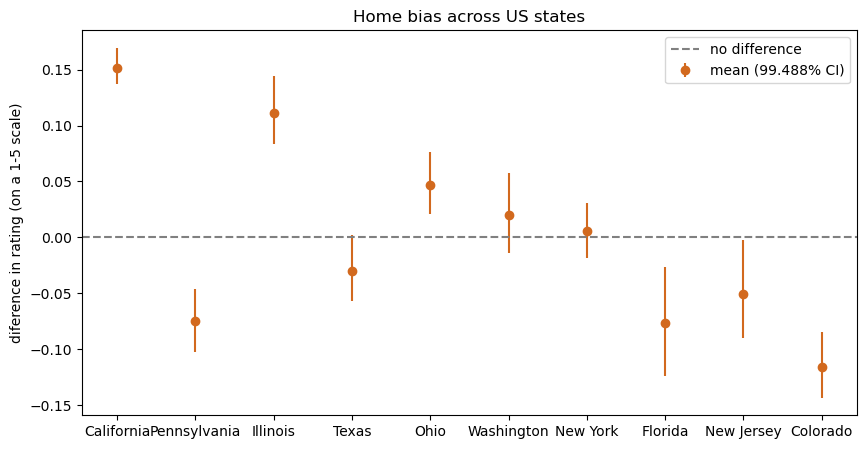

In [99]:
# computing error bars
df_results_us["err_low"] = df_results_us["diff_user_mean"] - df_results_us["diff_user_low"]
df_results_us["err_high"] = df_results_us["diff_user_high"] - df_results_us["diff_user_mean"]

# plotting
fig, ax = plt.subplots(figsize = (10, 5))
plt.errorbar([i for i in range(len(df_results_us))], df_results_us["diff_user_mean"].to_numpy(), yerr=df_results_us[["err_low", "err_high"]].transpose().to_numpy(), fmt = 'o', color = 'chocolate', label = f"mean ({(1 - alpha_1)*100:.3f}% CI)")
ax.axhline(0, 0, 1, linestyle = "--", color = "gray", label = "no difference")
plt.xticks([i for i in range(len(df_results_us))], topten_states)
plt.ylabel("diference in rating (on a 1-5 scale)")
plt.title("Home bias across US states")
plt.legend(loc = "upper right")
plt.savefig("Images/homebias_confidence_intervall_states.jpg", dpi = 500)
plt.show()

In [104]:
# plotly
plotly_states = plot_confidence_intervall(df_results_us, ticks=topten_states, region = "state")

Once again, the results are quite different when grouping users per states. Altough the overall difference was small, most of states have a difference in the 0.05 to 0.15 range, which is quite important. Contrary to countries, it is hard to see a geographical trend wether some states are more prone to have positive or negative biases toward their local beer compared to foreign ones.

 ## Creating datapane for the website

In [106]:
alpha_1

0.005116196891823743

In [107]:
import datapane as dp
# create datapane:

method_distribution_1 = dp.Text('The ratings of each dataset are split into two groups: local when the user rates a beer from its own counry and foreign. To accounts for difference in users critic level bias and beer quality , we compute user and beer bias vectors by performing [matrix factorization with biases](https://surprise.readthedocs.io/en/stable/matrix_factorization.html?highlight=matrix%20factorization) on the user-beer review matrix. Each rating is approximated by:')

matrix_formula = dp.Formula(r"\hat r_{user,beer} = \mu + b_{user} + b_{beer} + q_{beer}^T p_{user}")

method_distribution_2 = dp.Text('from wich we recover the user and beer biases vectors. The reviews are then put into bins of equal frequency in user and beer biases, then approximaely matched by resampling the majoritarian group within each bin. Once the dataset is balanced, we run a t-test to compare the mean rating of local and foreign reviews. We find a small, but significant difference. Analysis is performed on the BeerAdvocate dataset and per US state on the RateBeer dataset.')

app = dp.App(
    dp.Page(title= "Between Countries", blocks=[dp.Media(file="Images/rating_distribution_homebias.jpg", name="home_bias_distribution")]),
    dp.Page(title= "Between US States", blocks=[dp.Media(file="Images/rating_distribution_homebias_us.jpg", name="home_bias_distribution_us")]),
    dp.Page(title="Method", blocks=["# Method", method_distribution_1, matrix_formula, method_distribution_2]))


app.save(path="Pages/home_bias.html")

method_country = dp.Text('We group our review by user country and repeat the matching for each country (respectively US states) in the top 10 number of reviews in the dataset. We compute the mean difference between the two groups and confidence intervals using bootstraping and sidak-corrected significance level (0.51%). Analysis is performed on the BeerAdvocate dataset and per US state on the RateBeer dataset.')

app = dp.App(
    dp.Page(title= "Per Country", blocks=[dp.Plot(plotly_country, name="home_bias_confidence_countries")]),
    dp.Page(title= "Per US State", blocks=[dp.Plot(plotly_states, name="home_bias_confidence_states")]),
    dp.Page(title="Method", blocks=["# Method", method_country]))

app.save(path="Pages/home_bias_countries.html")


App saved to ./Pages/home_bias.html

App saved to ./Pages/home_bias_countries.html

 ### (discarded) Matrix factorization: comparison of bias vectors between control and treatment groups
 The idea of this method is to perform two separate matrix factorization on the control and treatment groups, and compare the bias vectors. This method has been discarded for two reasons:
 - It didn't help to rebalance the dataset because the method didn't involve some kind of matching between the groups. Therefor, it didn't add much compared to the initial naive approach.
 - It wasn't clear if the biases from matrix factorization where scaled to the rating and therefor the result couldn't be compared with the other methods.
 the code is left here for reference.

In [ ]:
df_treatment = df_sample[df_sample["treatment"] == 1]
df_control = df_sample[df_sample["treatment"] == 0]

# balance the number of reviews in the control and treatment groups
df_treatment = df_treatment.sample(n = 924)
df_control = df_control.sample(n = 924)

user_bias_treatment, beer_bias_treatment = get_biases(df_treatment)
user_bias_control, beer_bias_control = get_biases(df_control)

In [ ]:
# plot the difference in bias vectors between control and treatment groups
plt.hist(user_bias_treatment, label="treatment", alpha = 0.5, bins = 25)
plt.hist(user_bias_control, label="control", alpha = 0.5, bins = 25)
plt.title("user bias")
plt.legend()
plt.show()
plt.hist(beer_bias_treatment, label="treatment", alpha = 0.5, bins = 25)
plt.hist(beer_bias_control, label="control", alpha = 0.5, bins = 25)
plt.title("beer bias")
plt.legend()
plt.show()

In [ ]:
# run a t-test on the difference in bias vectors
res = ttest_ind(user_bias_treatment, user_bias_control)
print(res)
# print difference in mean
print(np.mean(user_bias_treatment) - np.mean(user_bias_control))
res = ttest_ind(beer_bias_treatment, beer_bias_control)
print(res)
print(np.mean(beer_bias_treatment) - np.mean(beer_bias_control))
